# Self-Driving Car Engineer Nanodegree

## Computer Vision & Deep Learning

## Project: Build an Vehicle Detection & Tracking Pipeline

The goals of this project are to:
    1. Perform camera calibration using a set of chessboard images
    2. Correct for distortion in raw images using the camera callibration matrix and distortion coefficients
    3. Apply a color transform, spatial binning of images for obtaining color-data.
    4. Perform a Histogram of Oriented Gradients (HOG) frature extraction to obtain/estimate structure-data. 
    3. Ensure that these features are normalized/scaled, and train a classifier on these images.
    4. Implement a sliding-window technique with multi-scale windows to search for vehicles in images.
    5. Create a heat-map of recurring detections frame-by-frame to reject outliers and false positives.
    6. Follow detected vehicles, and estimate/draw a bounding box for vehicles detected.
All major intermediate functions are in separate notebooks/python files for ease/modularity.
Additionally, this pipeline for vehicle detecting & tracking can be combined with the advanced-lane finding pipeline to create an algorithm that simultaneously detects lane-lines as well as performs vehicle-tracking.

## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS

import math
import time
import os
import os.path as path
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.metrics import accuracy_score

from datetime import datetime
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Step 1: Camera Calibration (from Advanced Lane-finding pipeline)

Extracting 3D object, and 2D image arrays from sample chessboard images.
Camera Calibration initialized.
Detected corners for image 0.
Detected corners for image 1.
Detected corners for image 3.
Detected corners for image 4.
Detected corners for image 6.
Detected corners for image 7.
Detected corners for image 8.
Detected corners for image 9.
Detected corners for image 10.
Detected corners for image 11.
Detected corners for image 12.
Detected corners for image 14.
Detected corners for image 15.
Detected corners for image 16.
Detected corners for image 17.
Detected corners for image 18.
Detected corners for image 19.
(9,6) pattern corners cannot be detected in 3 images in the camera_cal folder.


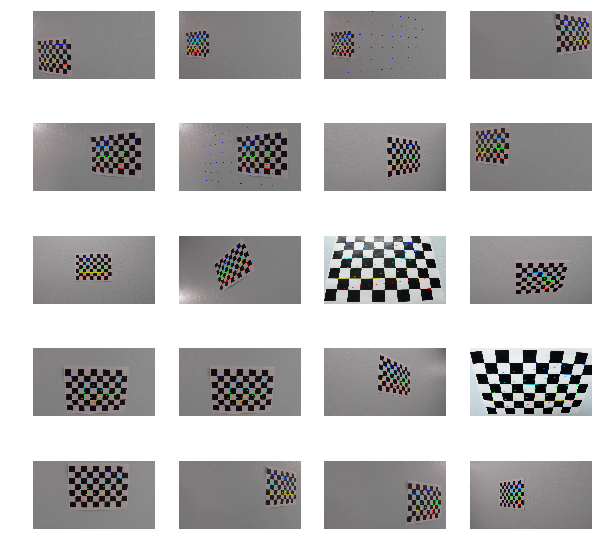

In [2]:
from camera_image_calibration import calibrate_camera

print("Extracting 3D object, and 2D image arrays from sample chessboard images.")
path='camera_cal/calibration*.jpg'
obj_array,img_array,cal_images,uncal_images=calibrate_camera(path)

Using image and object arrays to calibrate & undistort camera images.
Pickle exists, ignoring pickle creation step.


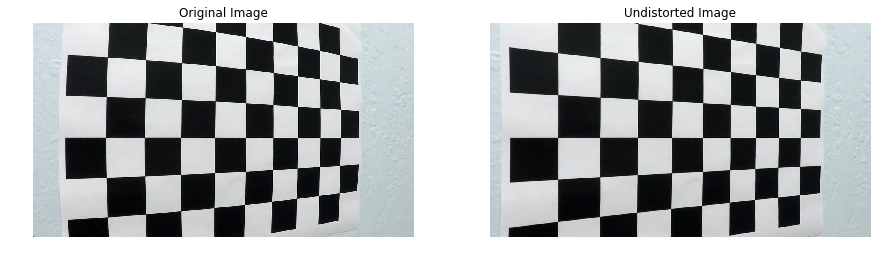

In [3]:
from camera_image_calibration import undistortion

print("Using image and object arrays to calibrate & undistort camera images.")

test_imagepath='camera_cal/calibration5.jpg'
src_image=cv2.imread(test_imagepath)

undistorted_image, camera_matrix, distortion_coefficients=undistortion(src_image,obj_array,img_array)

pickle_path="undistortion_pickle.p"

if (os.path.isfile(pickle_path)):
    print("Pickle exists, ignoring pickle creation step.")
else:
    try:
        print("Pickling camera matrix and distortion coefficients.")
        pickled=open(pickle_path,'wb')
        save={
            'dist_matrix': camera_matrix,
            'dist_coefficients': distortion_coefficients
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Data pickled.")
    except:
        print("Error in pickling. Debug.")

fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(15,10))
ax_orig.imshow(src_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_undist.imshow(undistorted_image)
ax_undist.axis('off')
ax_undist.set_title('Undistorted Image')

## Step 2: Distortion Correction (from Advanced Lane-finding pipeline)

In [4]:
from camera_image_calibration import undistort

# Load saved pickled data for matrix and distortion coefficients
pickle_path='undistortion_pickle.p'

with open(pickle_path,mode='rb') as f:
        undistort_data=pickle.load(f)
undistort_camera_matrix,undistort_coefficients=undistort_data['dist_matrix'], undistort_data['dist_coefficients']

print("Loading image undistortion coefficients, matrix from {}.".format(pickle_path))

Loading image undistortion coefficients, matrix from undistortion_pickle.p.


Testing out undistortion algorithm on sample chessboard images.


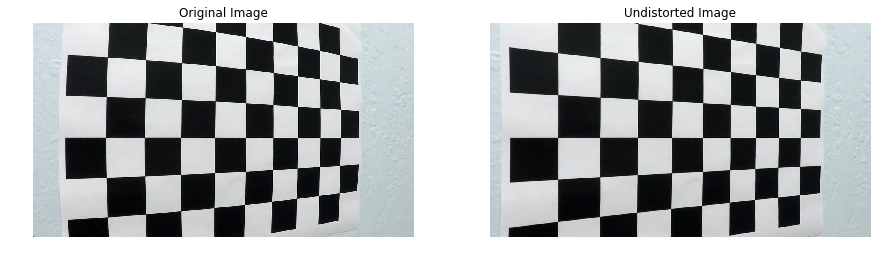

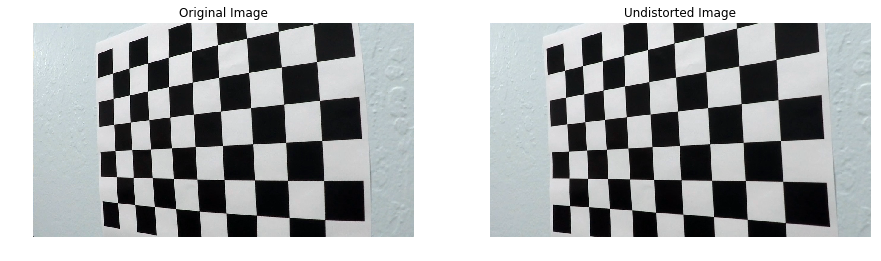

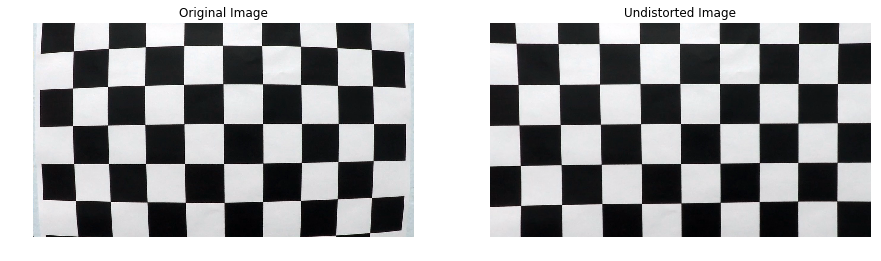

In [5]:
# Test out undistortion on chessboard images which weren't able to be used for finding corners
print("Testing out undistortion algorithm on sample chessboard images.")
num_plots=3
count=0

for image in uncal_images:
    fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(15,10))

    ax_orig.imshow(image)
    ax_orig.set_title('Original Image')
    ax_orig.axis('off')
    
    ax_undist.imshow(undistort(image,undistort_camera_matrix,undistort_coefficients))
    ax_undist.set_title('Undistorted Image')
    ax_undist.axis('off')
        
    if count>=num_plots:
        break
    count+=1

Testing out undistortion algorithm on sample driving camera image.


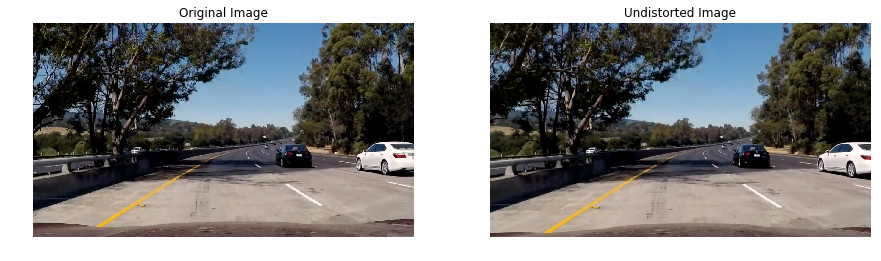

In [6]:
# Test out undistortion on a test_image 
from feature_analysis import display

print("Testing out undistortion algorithm on sample driving camera image.")

test_imagepath='test_images/test5.jpg'
test_image=display(cv2.imread(test_imagepath))
undistort_image=undistort(test_image,undistort_camera_matrix,undistort_coefficients)
fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(15,10))
ax_orig.imshow(test_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_undist.imshow(undistort_image)
ax_undist.axis('off')
ax_undist.set_title('Undistorted Image')

## Step 3: Dataset exploration

In [7]:
from feature_analysis import display

print("Dataset exploration and visualization.")

vehicles_path='datasets/vehicles/*/*.png'
nonvehicles_path='datasets/non-vehicles/*/*.png'
save_raw_pickle_path='raw_dataset.p'
redo=0
if (os.path.isfile(save_raw_pickle_path) and redo==0):
    print("Pickle exists, ignoring pickle creation step.")
else:
    try:
        cars=[]
        noncars=[]

        print("Loading required data...")
        vehicle_images=glob.glob(vehicles_path)
        other_images=glob.glob(nonvehicles_path)

        for img in vehicle_images:
            cars.append(display(cv2.imread(img)))
        for img in other_images:
            noncars.append(display(cv2.imread(img)))

        cars=np.asarray(cars)
        noncars=np.asarray(noncars)
        print("Arrays created.")

        print("Pickling raw car- and non-car dataset images.")
        pickled=open(save_raw_pickle_path,'wb')
        save={
            'car': cars,
            'non_car': noncars
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Data pickled.")
    except:
        print("Error in pickling. Debug.")

Dataset exploration and visualization.
Pickle exists, ignoring pickle creation step.


In [8]:
with open(save_raw_pickle_path,mode='rb') as f:
        car_data=pickle.load(f)
car_dataset,noncar_dataset=car_data['car'], car_data['non_car']

print("Loading raw image dataset from {}.".format(save_raw_pickle_path))
print("Dataset contains {} car images & {} non-car images.".format(len(car_dataset),len(noncar_dataset)))
print("Images are of shape: {}.\n".format(car_dataset[0].shape))

car_dataset.flags.writeable=False
noncar_dataset.flags.writeable=False
car_hash=set([hash(image.tobytes()) for image in car_dataset])
noncar_hash=set([hash(image.tobytes()) for image in noncar_dataset])
car_duplicates=len(car_dataset)-len(car_hash)
noncar_duplicates=len(noncar_dataset)-len(noncar_hash)

print("There are {} duplicate images in car_dataset, {} duplicate images in noncar_dataset.".
      format(car_duplicates,noncar_duplicates))

Loading raw image dataset from raw_dataset.p.
Dataset contains 8792 car images & 8968 non-car images.
Images are of shape: (64, 64, 3).

There are 16 duplicate images in car_dataset, 173 duplicate images in noncar_dataset.


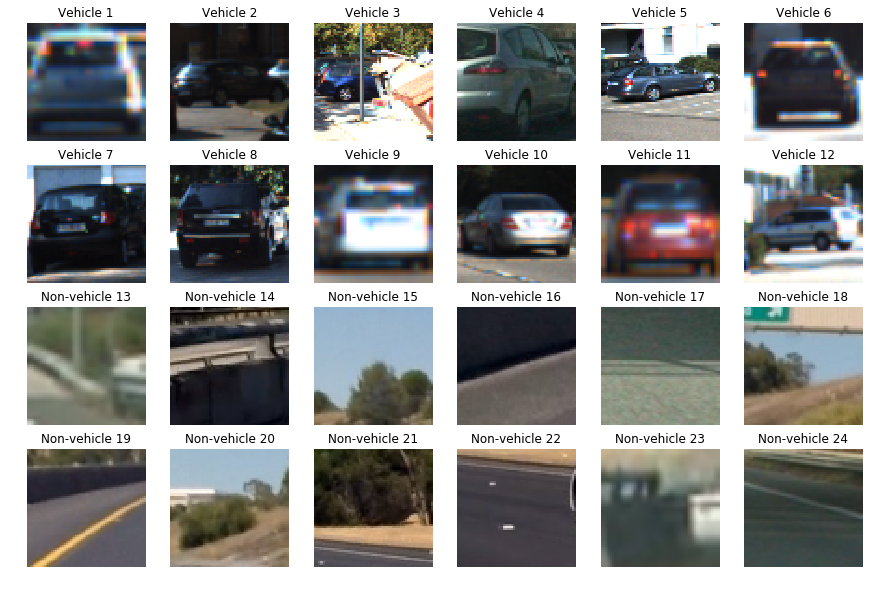

In [9]:

fig, ax=plt.subplots(4,6, figsize=(15, 10))
ax=ax.ravel()
for i in np.arange(12):
    c_ind=np.random.randint(0,len(car_dataset))
    img=(car_dataset[c_ind])
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title('Vehicle {}'.format(i+1))
for i in np.arange(12,24):
    nc_ind=np.random.randint(0,len(noncar_dataset))
    img=(noncar_dataset[nc_ind])
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title('Non-vehicle {}'.format(i+1))

## Step 4: Feature Extraction & Dataset Creation

1. Colorspace: YUV
2. Color Histogram: 32 bins, color-range from 0-256
3. Spatial Bins: Resize & Blurring to (32,32) image
4. HOG Spatial structure: 11 Orientations, 16 pixels-per-cell, 2 cells-per-block, 'ALL' channels used

In [10]:
from feature_analysis import feature_extraction

save_finaldataset_pickle_path='extracted_dataset.p'
redo=0
if (os.path.isfile(save_finaldataset_pickle_path) and redo==0):
    print("Pickle exists, ignoring dataset extraction step.")
    pass
else:
    print("Extracting features and augmenting dataset.")

    t0_fext=time.time()
    modified_car_features=feature_extraction(car_dataset,
                                         c_space='YCrCb',
                                         orient=9,
                                         pix_per_cell=8,
                                         cell_per_block=2,
                                         use_histogram=True,
                                         use_spatialbins=True,
                                         use_hog=True,
                                         hog_channel='ALL')

    modified_noncar_features=feature_extraction(noncar_dataset,
                                         c_space='YCrCb',
                                         orient=9,
                                         pix_per_cell=8,
                                         cell_per_block=2,
                                         use_histogram=True,
                                         use_spatialbins=True,
                                         use_hog=True,
                                         hog_channel='ALL')
    # Features
    X=np.vstack((modified_car_features,modified_noncar_features)).astype(np.float64)

    t1_fext=time.time()

    # Labels [1=Car, 0=Not-Car]
    y=np.hstack((np.ones(len(modified_car_features)),
                 np.zeros(len(modified_noncar_features))))

    print("Features extracted in {} seconds. Extracted features has shape {}.".format(round(t1_fext-t0_fext,4),X.shape))

Pickle exists, ignoring dataset extraction step.


In [11]:
# Find the optimium number of components for dimension reduction using a simple/Linear-SVM classifier
from feature_analysis import pca_ocheck

redo=0
if redo==0:
    print("Ignoring Randomized Grid Search to find optimum components for Principal-Component Analysis.")
    pass
else:
    t0_process=time.time()
    print("Normalizing features and performing dimension reduction grid-search.")
    X_Scaler=StandardScaler().fit(X)
    X_scaled=X_Scaler.transform(X)
    t1_process=time.time()
    
    results,choice=pca_ocheck(X_scaled,y)
    print("Randomized Search CV results in {} seconds after normalization.".format(round(t1_process-t0_process,4)))
    print("Cross-Validation Results:", results)
    print("Best Estimator:", choice)

Ignoring Randomized Grid Search to find optimum components for Principal-Component Analysis.


In [12]:
# Normalizing features and performing dimension reduction grid-search.
# GridSearchCV took 9242.58 seconds.
# Randomized Search CV results in 2.3322 seconds after normalization.

# Cross-Validation Results: {'std_test_score': array([ 0.15657613,  0.15670462,  0.15738436,  0.15782115,  0.15806214,
#         0.15829891,  0.15817847,  0.15825809,  0.15817847,  0.15833976,
#         0.15826015,  0.15826015]), 'params': ({'pca__n_components': 500}, {'pca__n_components': 1000}, {'pca__n_components': 1500}, {'pca__n_components': 2000}, {'pca__n_components': 2500}, {'pca__n_components': 3000}, {'pca__n_components': 3500}, {'pca__n_components': 4000}, {'pca__n_components': 4500}, {'pca__n_components': 5000}, {'pca__n_components': 5500}, {'pca__n_components': 6000}), 'split0_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 'mean_score_time': array([ 1.7859962 ,  2.03717081,  3.07891123,  3.77187936,  4.82051555,
#         4.87192861,  5.43084764,  6.04717739,  5.66502547,  6.4027648 ,
#         6.6290954 ,  8.09369787]), 'std_train_score': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'std_fit_time': array([ 14.45541092,   7.20383487,   5.0696978 ,  10.98083053,
#         31.01991719,  12.69207427,  15.7088384 ,  29.87115457,
#         16.78928768,  22.09523354,   1.04850073,  11.4687122 ]), 'split1_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 'rank_test_score': array([12,  1,  4, 11, 10,  6,  6,  9,  6,  4,  2,  2], dtype=int32), 'split0_test_score': array([ 0.65580138,  0.6573214 ,  0.65597028,  0.65478804,  0.65478804,
#         0.65461915,  0.65478804,  0.65461915,  0.65478804,  0.65461915,
#         0.65478804,  0.65478804]), 'std_score_time': array([ 0.96282068,  0.64725233,  0.01488494,  0.06204786,  0.80381968,
#         0.37328618,  0.78037232,  1.27258585,  0.09352139,  0.59168074,
#         0.19037434,  0.80743341]), 'split2_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 'param_pca__n_components': masked_array(data = [500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000],
#              mask = [False False False False False False False False False False False False],
#        fill_value = ?)
# , 'split2_test_score': array([ 0.98614631,  0.98699105,  0.9868221 ,  0.98665315,  0.98699105,
#         0.98749789,  0.98749789,  0.98749789,  0.98749789,  0.98749789,
#         0.98749789,  0.98749789]), 'mean_test_score': array([ 0.87719595,  0.87888514,  0.87849099,  0.87792793,  0.87826577,
#         0.87843468,  0.87843468,  0.87837838,  0.87843468,  0.87849099,
#         0.8785473 ,  0.8785473 ]), 'mean_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 'mean_fit_time': array([  48.4102006 ,   52.64779631,   84.56257908,  113.32579144,
#         187.25225902,  202.71206443,  267.57294607,  279.05735334,
#         325.32381574,  395.70519574,  415.10092227,  487.67205811]), 'split1_test_score': array([ 0.98969595,  0.99239865,  0.99273649,  0.99239865,  0.99307432,
#         0.99324324,  0.99307432,  0.99307432,  0.99307432,  0.99341216,
#         0.99341216,  0.99341216])}

# Best Estimator: Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
#   svd_solver='randomized', tol=0.0, whiten=False)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0))])

In [13]:
from feature_analysis import perform_pca

redo=0
if (os.path.isfile(save_finaldataset_pickle_path) and redo==0):
    print("Pickle exists, ignoring dataset extraction step.")
#     X_Scaler=StandardScaler().fit(X)

    pass
else:
    t0_process=time.time()
    print("Normalizing features and performing dimension reduction.")
    X_Scaler=StandardScaler().fit(X)
    X_scaled=X_Scaler.transform(X)
    # Save Scaler
    scalerfile = 'X_Scaler.save'
    scaler= joblib.dump(X_Scaler,scalerfile)
    print("Saved X_scaler.")
    
    #X_reduced,pca_model=perform_pca(X_scaled,n_components=1000,perform_pca=True)
    # Save PCA model
    #pcafile='pca.save'
    #pcasave=joblib.dump(pca_model,pcafile)
    #print("Saved PCA model")
    
    t1_process=time.time()

    print("Dataset normalized and has dimension reduced in {} s. Dataset is of shape {}.".format(round(t1_process-t0_process,4),X_scaled.shape))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.20)

Pickle exists, ignoring dataset extraction step.


In [14]:
redo=0
if (os.path.isfile(save_finaldataset_pickle_path) and redo==0):
    print("Pickle exists, ignoring pickle creation step.")
    pass
else:
    try:
        print("Pickling dataset...")
        pickled=open(save_finaldataset_pickle_path,'wb')
        save={
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Data pickled.")
    except:
        print("Error in pickling. Debug.")

Pickle exists, ignoring pickle creation step.


In [15]:
with open(save_finaldataset_pickle_path,mode='rb') as f:
    extracted_data=pickle.load(f)
    
X_train,X_test,y_train,y_test=extracted_data['X_train'],extracted_data['X_test'],extracted_data['y_train'],extracted_data['y_test']

print("X_train shape: {} ... y_train shape: {}".format(X_train.shape,y_train.shape))
print("X_test shape: {} ... y_test shape: {}".format(X_test.shape,y_test.shape))

Xtrain_c1=len(X_train[y_train==1])/len(X_train)
Xtrain_c2=len(X_train[y_train==0])/len(X_train)
Xtest_c1=len(X_test[y_test==1])/len(X_test)
Xtest_c2=len(X_test[y_test==0])/len(X_test)

print("Training dataset has {} % of data from class <<Car>> & {} % of data from class <<non-Car>>.".format(
round(Xtrain_c1*100,2),round(Xtrain_c2*100,2)))

print("Testing dataset has {} % of data from class <<Car>> & {} % of data from class <<non-Car>>.".format(
round(Xtest_c1*100,2),round(Xtest_c2*100,2)))

X_train shape: (14208, 6156) ... y_train shape: (14208,)
X_test shape: (3552, 6156) ... y_test shape: (3552,)
Training dataset has 49.61 % of data from class <<Car>> & 50.39 % of data from class <<non-Car>>.
Testing dataset has 49.1 % of data from class <<Car>> & 50.9 % of data from class <<non-Car>>.


Data has been extracted, normalized (as it contains features from color histogram, spatial binning, and HOG spatial-features), and has dimensionality reduction done to it (PCA) to find latent features and remove unnecessary features. Both the training and testing dataset can be seen to be balanced among the two classes.

## Step 5: Classifier Creation

In [16]:
from classifiers import linear_svm

lsvm_clf,lsvm_accuracy,lsvm_train_time=linear_svm(X_train,y_train,X_test,y_test)
print("Linear Support-Vector Classifier trained in {} s : {} % accuracy".format(lsvm_train_time,lsvm_accuracy))

Linear Support-Vector Classifier trained in 18.8478 s : 99.3243 % accuracy


## Step 6: Image Tests

In [17]:
# Loading appropriate classifier model

adaboost='adaboost_classifier.p'
lin_svm='linear_svm_classifier.p'
svm='svm_classifier.p'
ensemble='ensemble_classifier.p'

chosen_model='lin_svm'

if chosen_model=='lin_svm':
    classifier=pickle.load(open(lin_svm,'rb'))
    path=lin_svm
elif chosen_model=='svm':
    classifier=pickle.load(open(svm,'rb'))
    path=svm
elif chosen_model=='adaboost':
    classifier=pickle.load(open(adaboost,'rb'))
    path=adaboost
elif chosen_model=='ensemble':
    classifier=pickle.load(open(ensemble,'rb'))
    path=ensemble

print("Using {} model loaded from {}.".format(classifier,path))

Using LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) model loaded from linear_svm_classifier.p.


In [18]:

samples=15
predictions=classifier.predict(X_test[0:samples])
true=y_test[0:samples]
accuracy=100*accuracy_score(true,predictions)
print("Classifier predictions over {} samples.".format(samples))

print("Predictions: ",predictions )
print("Labels: ",true)
print("Accuracy score of {} %.".format(round(accuracy,4)))

Classifier predictions over 15 samples.
Predictions:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  0.  1.]
Labels:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  0.  1.]
Accuracy score of 100.0 %.


In [19]:
# Test images to be used
test_image_1=mpimg.imread('./test_images/test1.jpg')
test_image_2=mpimg.imread('./test_images/test2.jpg')
test_image_3=cv2.resize(mpimg.imread('./test_images/test7.jpg'),(1280,720))

test_images=np.stack((test_image_1,test_image_2,test_image_3))

Detecting cars in test images using a search window (single-scale).


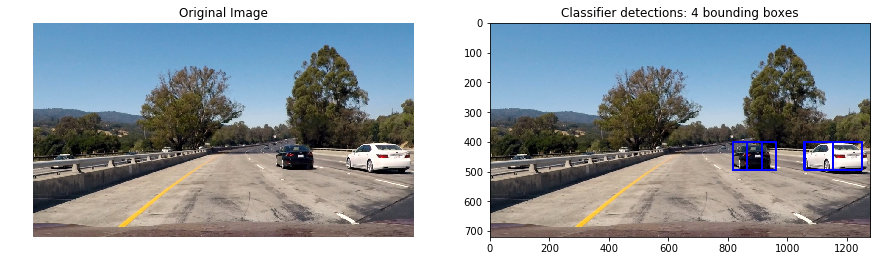

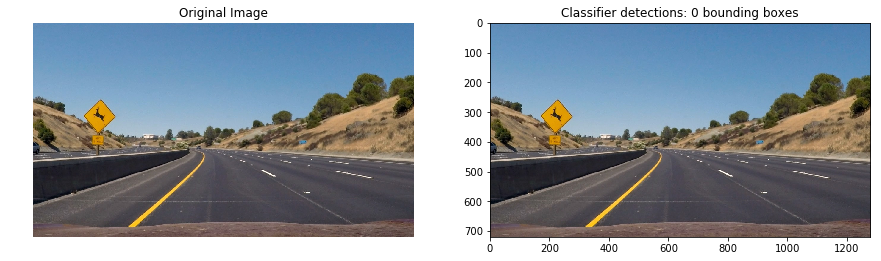

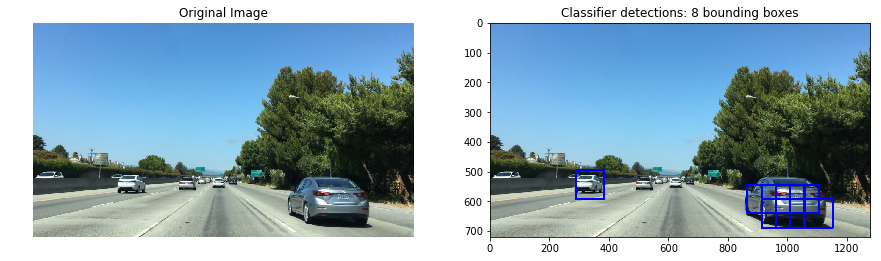

In [20]:
from tracking_utility import detect_cars, draw_boxes, ROI, slide_window

print("Detecting cars in test images using a search window (single-scale).")
X_Scaler=joblib.load('X_Scaler.save') 
#pca_model=joblib.load('pca.save')

for image in test_images:
    copy=np.copy(image)
    vertices=np.asarray([[[0,400],[image.shape[1],400],[image.shape[1],image.shape[0]],
                          [0,image.shape[0]]]],dtype=np.int32)
        
    roi_image=ROI(copy,vertices) # Region of Interest+Vertices

    windows=slide_window(roi_image, x_start_stop=[None,None], y_start_stop=[400,720], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)) # Sliding window search
    bboxes=detect_cars(raw_image=roi_image,
                    window_list=windows,classifier=classifier,
                    X_scaler=X_Scaler,c_space='YCrCb',
                    orient=9,pix_per_cell=8,cell_per_block=2,
                    spatial_size=(16,16),hist_bins=32)
    
    fig,(ax_orig,ax_bbox)=plt.subplots(1,2,figsize=(15,10))
    ax_orig.imshow(image)
    ax_orig.axis('off')
    ax_orig.set_title('Original Image')

    ax_bbox.imshow(draw_boxes(image,bboxes))
    ax_bbox.axis('on')
    ax_bbox.set_title('Classifier detections: {} bounding boxes'.format(len(bboxes)))
    

Formulating heatmaps


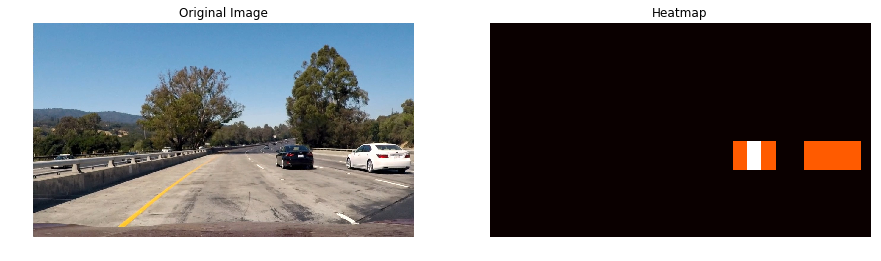

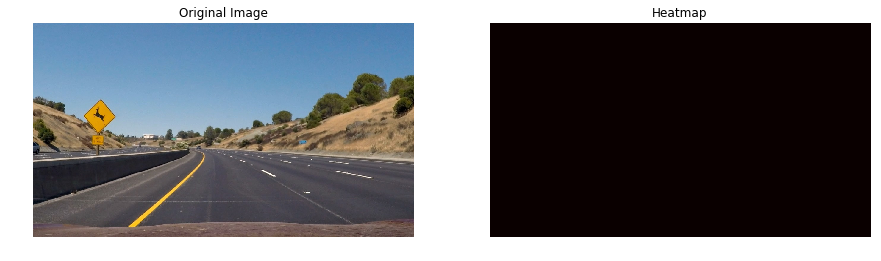

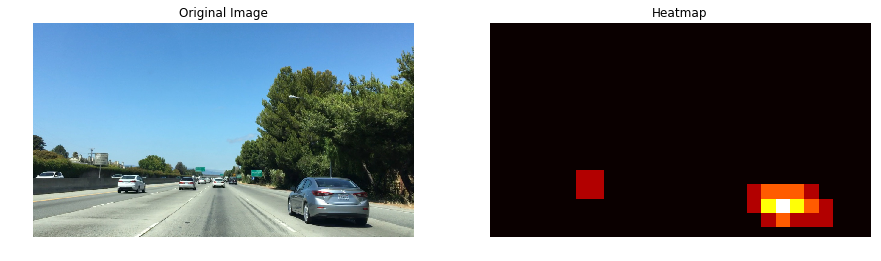

In [21]:
from tracking_utility import add_heat, apply_heat_threshold

print("Formulating heatmaps")

for image in test_images:
    copy=np.copy(image)
    vertices=np.asarray([[[0,400],[image.shape[1],400],[image.shape[1],image.shape[0]],
                          [0,image.shape[0]]]],dtype=np.int32)
        
    roi_image=ROI(copy,vertices) # Region of Interest+Vertices

    windows=slide_window(roi_image, x_start_stop=[None,None], y_start_stop=[400,720], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)) # Sliding window search
    bboxes=detect_cars(raw_image=roi_image,
                    window_list=windows,classifier=classifier,
                    X_scaler=X_Scaler,c_space='YCrCb',
                    orient=9,pix_per_cell=8,cell_per_block=2,
                    spatial_size=(16,16),hist_bins=32)
    
    heatmap=np.zeros_like(image[:,:,0])
    heatmap=add_heat(heatmap,bboxes) # Where bboxes are bounding boxes
    
    fig,(ax_orig,ax_heat)=plt.subplots(1,2,figsize=(15,10))
    ax_orig.imshow(image)
    ax_orig.axis('off')
    ax_orig.set_title('Original Image')

    ax_heat.imshow(heatmap,cmap='hot')
    ax_heat.axis('off')
    ax_heat.set_title('Heatmap')

Adding heatmap thresholding
Removes any possible false positives/multiple detections.


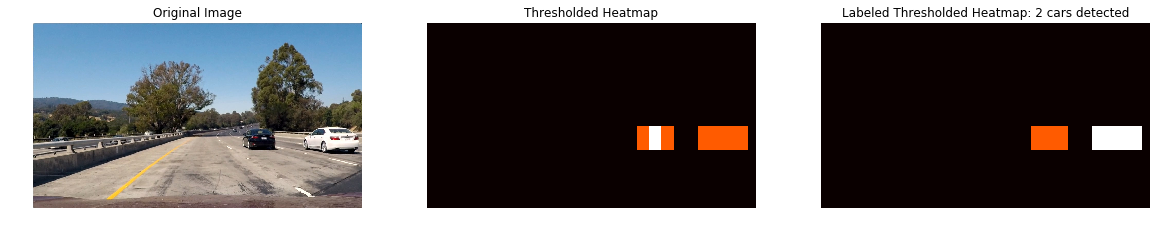

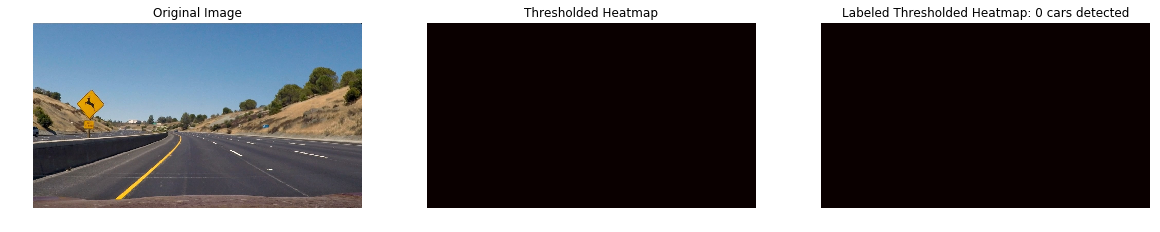

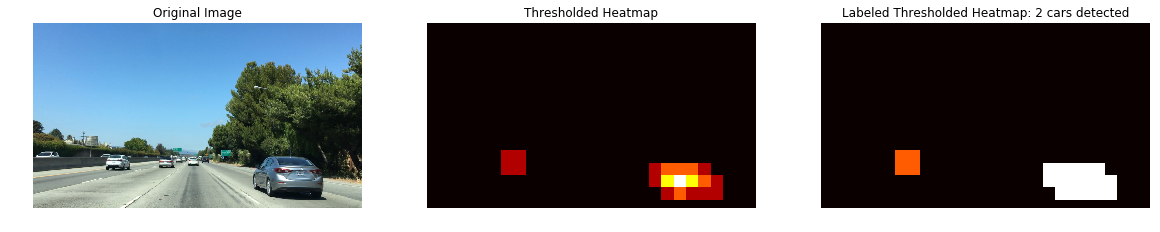

In [22]:
print("Adding heatmap thresholding")
print("Removes any possible false positives/multiple detections.")

for image in test_images:
    copy=np.copy(image)
    vertices=np.asarray([[[0,400],[image.shape[1],400],[image.shape[1],image.shape[0]],
                          [0,image.shape[0]]]],dtype=np.int32)
        
    roi_image=ROI(copy,vertices) # Region of Interest+Vertices

    windows=slide_window(roi_image, x_start_stop=[None,None], y_start_stop=[400,720], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)) # Sliding window search
    bboxes=detect_cars(raw_image=roi_image,
                    window_list=windows,classifier=classifier,
                    X_scaler=X_Scaler,c_space='YCrCb',
                    orient=9,pix_per_cell=8,cell_per_block=2,
                    spatial_size=(16,16),hist_bins=32)
    heatmap=np.zeros_like(image[:,:,0])
    heatmap=add_heat(heatmap,bboxes) # Where bboxes are bounding boxes

    heatmap=apply_heat_threshold(heatmap,0.5)

    fig,(ax_orig,ax_heat,ax_thresh)=plt.subplots(1,3,figsize=(20,20))
    ax_orig.imshow(image)
    ax_orig.axis('off')
    ax_orig.set_title('Original Image')

    ax_heat.imshow(heatmap,cmap='hot')
    ax_heat.axis('off')
    ax_heat.set_title('Thresholded Heatmap')

    # Labeling
    car_labels=label(heatmap) 
    ax_thresh.imshow(car_labels[0],cmap='hot')
    ax_thresh.axis('off')
    ax_thresh.set_title('Labeled Thresholded Heatmap: {} cars detected'.format(car_labels[1]))

## Step 7: Pipeline Implementation

In [ ]:
print("Utilizing vehicle detection & tracking pipeline on video feed.")

from pipelines import Tracking_pipeline

vehicle_tracking_pipeline=Tracking_pipeline(classifier=classifier,X_scaler=X_Scaler)

### Video Pipeline- Test Video

In [ ]:
test_output = 'test_videos_output/test_video.mp4'
clip1 = VideoFileClip("test_videos/test_video.mp4")
test_clip = clip1.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

### Video Pipeline- Main Video

In [ ]:
main_output = 'test_videos_output/project_video.mp4'
clip2 = VideoFileClip("test_videos/project_video.mp4")
main_clip = clip2.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time main_clip.write_videofile(main_output, audio=False)

### Video Pipeline- Main Challenge Video

In [ ]:
main_challenge_output = 'test_videos_output/main_challenge_video.mp4'
clip3 = VideoFileClip("test_videos/main_challenge_video.mp4")
main_challenge_clip = clip3.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time main_challenge_clip.write_videofile(main_challenge_output, audio=False)

### Video Pipeline- Main Harder Challenge Video

In [ ]:
main_harder_challenge_output = 'test_videos_output/main_harder_challenge_video.mp4'
clip4 = VideoFileClip("test_videos/main_harder_challenge_video.mp4")
main_harder_challenge_clip = clip4.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time main_harder_challenge_clip.write_videofile(main_harder_challenge_output, audio=False)

### Video Pipeline- Supplementary Videos: Night Driving

In [ ]:
alternative_sample_night_drive_output = 'test_videos_output/alternative_sample_night_drive.mp4'
clip5 = VideoFileClip("test_videos/alternative_sample_night_drive.mp4")
alternative_sample_night_drive_clip = clip5.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time alternative_sample_night_drive_clip.write_videofile(alternative_sample_night_drive_output, audio=False)

### Video Pipeline- Supplementary Videos: Solid White Right Lane Lines

In [ ]:
alternative_solidWhiteRight_output = 'test_videos_output/alternative_solidWhiteRight.mp4'
clip6 = VideoFileClip("test_videos/alternative_solidWhiteRight.mp4")
alternative_solidWhiteRight_clip = clip6.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time alternative_solidWhiteRight_clip.write_videofile(alternative_solidWhiteRight_output, audio=False)

### Video Pipeline- Supplementary Videos: Long Highway

In [ ]:
alternative_highway_output = 'test_videos_output/alternative_sample_long_highway.mp4'
clip7 = VideoFileClip("test_videos/alternative_sample_long_highway.mp4")
alternative_highway_clip = clip7.fl_image(vehicle_tracking_pipeline.tracking) #NOTE: this function expects color images!!
%time alternative_highway_clip.write_videofile(alternative_highway_output, audio=False)

### Image Pipeline- Test Images

In [23]:
images_source='test_images/'
images_save='test_images_output/'

image_name_list=os.listdir(images_source)

print("Utilizing lane-finding pipeline on image feed.")

from pipelines import image_pipeline

Utilizing lane-finding pipeline on image feed.


Using image test2.jpg from test_images/...


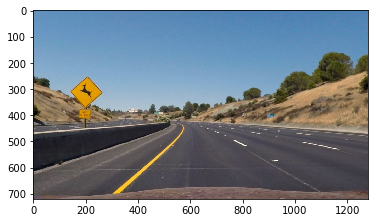

Saving image test2.jpg in test_images_output/...
Using image test6.jpg from test_images/...


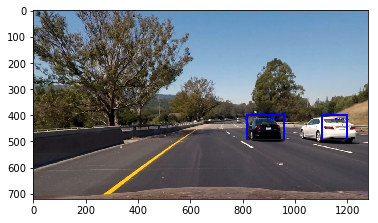

Saving image test6.jpg in test_images_output/...
Using image test3.jpg from test_images/...


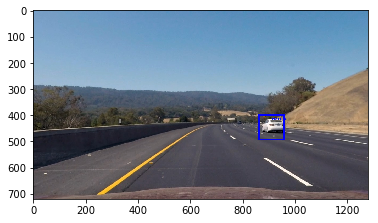

Saving image test3.jpg in test_images_output/...
Using image test4.jpg from test_images/...


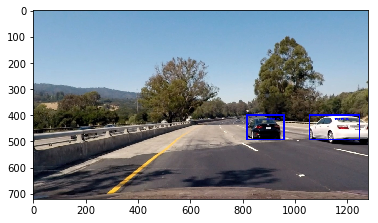

Saving image test4.jpg in test_images_output/...
Using image test7.jpg from test_images/...


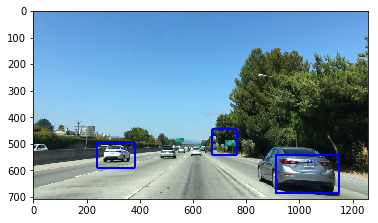

Saving image test7.jpg in test_images_output/...
Using image test1.jpg from test_images/...


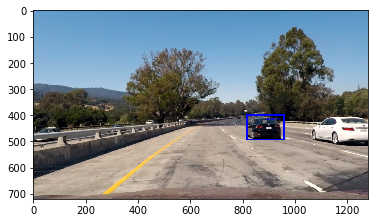

Saving image test1.jpg in test_images_output/...
Using image test5.jpg from test_images/...


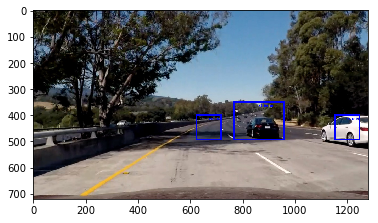

Saving image test5.jpg in test_images_output/...


In [24]:
for image_local in image_name_list:
    print("Using image {} from {}...".format(image_local,images_source))
    image=mpimg.imread(os.path.join(images_source,image_local))
        
    processed_image=image_pipeline(raw_image=image,X_scaler=X_Scaler,classifier=classifier,
                   undistort_matrix=undistort_camera_matrix,undistort_coefficients=undistort_coefficients)
    plt.imshow(processed_image)
    plt.show()

    print("Saving image {} in {}...".format(image_local,images_save))
    saved_image=cv2.imwrite(os.path.join(images_save,image_local),cv2.cvtColor(processed_image,cv2.COLOR_RGB2BGR))

In [25]:
print("Script terminated at",str(datetime.now()))

Script terminated at 2017-09-14 08:55:50.399107
